# 6.1 파이프라인을 사용한 효율적인 워크플로우
# 6.1.1 위스콘신 유방암 데이터셋

첫 두 열에는 고유 id와 진단결과(M=악성, B=양성), 나머지에는 세포 핵의 디지털 이미지에서 계산된 30개의 실수 값 특성이 담겨있음

In [1]:
import pandas as pd

df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [2]:
# 30개의 특성을 넘파이 배열 X에 할당하기
# 클래스 레이블을 문자열에서 정수형으로 변환하기

from sklearn.preprocessing import LabelEncoder

X = df.loc[:,2:].values
y = df.loc[:,1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

클래스 레이블(진단 결과)를 배열 y에 인코딩하면 악성(malignant)종양은 클래스 1, 양성(benign) 종양은 클래스 0으로 각각 표현된다.

In [3]:
le.transform(['M', 'B'])

array([1, 0])

In [4]:
# 데이터 셋 분할하기

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

# 6.1.2 파이프라인으로 변환기와 추정기 연결

피처가 다양한 스케일로 측정되었기 때문에 표준화가 필요함. PCA를 통해 2차원으로 데이터 압축

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(random_state=1))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('테스트 정확도: %.3f' % pipe_lr.score(X_test, y_test))

테스트 정확도: 0.956


make_pipeline 함수는 여러 개의 사이킷런 변환기와 추정기를 연결할 수 있다 -> 변환기와 추정기를 감싼 wrapper 형태로 생각하면 됨.  
파이프라인의 중간 단계 횟수는 제한이 없고, 파이프라인의 마지막 요소는 추정기가 되어야함.

# 6.2 k-겹 교차 검증을 사용한 모델 성능 평가
# 6.2.1 홀드아웃 방법
전통적이고 널리 사용되는 머신러닝 모델의 일반화 성능 추정방법  
초기 데이터셋을 별도의 훈련 데이터셋(-> 모델 훈련)과 테스트 데이터셋(-> 일반화 성능 추정)으로 나눠 사용  
일반적인 머신러닝 애플리케이션에서는 처음 본 데이터에서 예측 성능을 높이기 위해 하이퍼파라미터를 튜닝하고 비교함  
모델 선택: 주어진 분류 문제에서 튜닝할 파라미터의 최적 값을 선택하는 것. 과대적합을 피하기 위해 유의해야 함  
따라서, 모델 선택 시에 데이터를 훈련용, 검증용, 테스트용 세 부분으로 나누는 것이 가장 좋음  
다만 홀드아웃 방법은 훈련 데이터를 어떻게 훈련용과 검증용으로 나눌 것인가에 따라 성능 추정이 민감하게 반응함  
# 6.2.2 k-겹 교차 검증
k-겹 교차 검증에서는 중복을 허용하지 않고 훈련 데이터셋을 k개의 폴드로 랜덤하게 나눈다  
k-1개의 폴드로 모델을 훈련하고 나머지 하나의 폴드로 성능을 평가하며, 이를 k번 반복하여 k개의 모델과 성능 추정을 얻는다  
서로 독립적인 폴드에서 얻은 성능 추정을 기반으로 모델의 평균 성능을 계산 -> 홀드아웃보다 데이터 분할에 덜 민감  
일반적으로 모델 튜닝에 많이 사용됨

In [6]:
# solution (1)
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('폴드: %2d, 클래스 분포: %s, 정확도: %.3f' % (k+1, np.bincount(y_train[train]), score))

폴드:  1, 클래스 분포: [256 153], 정확도: 0.935
폴드:  2, 클래스 분포: [256 153], 정확도: 0.935
폴드:  3, 클래스 분포: [256 153], 정확도: 0.957
폴드:  4, 클래스 분포: [256 153], 정확도: 0.957
폴드:  5, 클래스 분포: [256 153], 정확도: 0.935
폴드:  6, 클래스 분포: [257 153], 정확도: 0.956
폴드:  7, 클래스 분포: [257 153], 정확도: 0.978
폴드:  8, 클래스 분포: [257 153], 정확도: 0.933
폴드:  9, 클래스 분포: [257 153], 정확도: 0.956
폴드: 10, 클래스 분포: [257 153], 정확도: 0.956


In [7]:
print('\nCV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


CV 정확도: 0.950 +/- 0.014


In [9]:
# solution (2)
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1)
print('CV 정확도 점수: %s' % scores)

CV 정확도 점수: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]


In [10]:
print('CV 정확도: %.3f ± %.3f' % (np.mean(scores), np.std(scores)))

CV 정확도: 0.950 ± 0.014


# 6.3 학습 곡선과 검증 곡선을 사용한 알고리즘 디버깅
# 6.3.1 학습 곡선으로 편향과 분산 문제 분석
주어진 훈련 데이터셋에 비해 모델이 너무 복잡하면(즉, 모델의 자유도나 파라미터가 너무 많으면) 모델이 훈련 데이터에 과대적합됨  
모델의 훈련 정확도와 검증 정확도를 훈련 데이터셋의 크기 함수로 그래프를 그려보면 문제점을 파악할 수 있음  
1. 편향이 높은 모델의 경우, 훈련 데이터에 과소 적합 -> 모델의 파라미터 개수 늘리기, SVM이나 로지스틱 회귀 분류기에서 규제 강도 줄이기  
2. 분산이 높은 모델의 경우, 훈련 데이터에 과대 적합 -> 훈련 데이터를 모으거나 모델 복잡도를 낮추거나 규제를 증가시키기

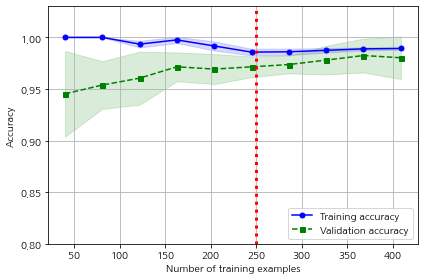

In [18]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', random_state=1, max_iter=10000))

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.axvline(x=250, color='r', linestyle=':', linewidth=3) # 유의미한 샘플 사이즈 표시를 위해 임의로 추가함

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

# 6.3.2 검증 곡선으로 과대적합과 과소적합 조사

검증 곡선은 과대적합과 과소적합 문제를 해결하여 모델 성능을 높일 수 있는 유용한 도구임.  
검증 곡선은 학습 곡선과 관련이 있지만 샘플 크기의 함수로 훈련 정확도와 테스트 정확도를 그리는 대신 모델 파라미터 값의 함수로 그림

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

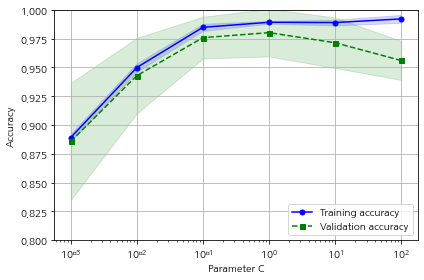

In [21]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr, X=X_train, y=y_train,
                                             param_name='logisticregression__C', param_range=param_range, cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')

plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

# 6.4 그리드 서치를 사용한 머신러닝 모델 세부 튜닝
1. 훈련 데이터에서 학습되는 파라미터 (ex. 로지스틱 회귀의 가중치)
2. 별도로 최적화되는 학습 알고리즘의 파라미터: 하이퍼 파라미터 (ex. 로지스틱 회귀의 규제 매개변수)  

# 6.4.1 그리드 서치를 사용한 하이퍼파라미터 튜닝
리스트로 지정된 여러가지 하이퍼 파라미터 값 전체를 모두 조사하여 최적의 조합을 찾음

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range, 'svc__kernel':['linear']},
             {'svc__C': param_range, 'svc__gamma':param_range, 'svc__kernel':['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, refit=True, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print('Best Score: ', gs.best_score_) # 최상의 모델 점수
print('Best Parameters: ', gs.best_params_) # 이 모델의 매개변수 속성

Best Score:  0.9846859903381642
Best Parameters:  {'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


독립적인 테스트 데이터셋을 사용하여 최고 모델의 성능을 추정

In [25]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)

print('테스트 정확도: %.3f' % clf.score(X_test, y_test))

테스트 정확도: 0.974


#### 랜덤한 하이퍼 파라미터 탐색
그리드 서치가 최적의 매개변수 조합을 찾을 수 있는 강력한 도구이지만, 가능한 모든 매개변수 조합을 평가하기 위해서는 많은 계산 비용이 소요됨  
사이킷런에는 여러가지 매개변수 조합을 샘플링하는 랜덤 서치 방식도 있으며, 이는 일반적으로 그리드 서치와 비슷한 성능이지만 훨씬 비용과 시간이 적게 듦

In [26]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform

distribution =  loguniform(0.0001, 1000.0)

param_dist = [{'svc__C': distribution, 
               'svc__kernel': ['linear']},
              {'svc__C': distribution, 
               'svc__gamma': distribution, 
               'svc__kernel': ['rbf']}]

rs = RandomizedSearchCV(estimator=pipe_svc,
                        param_distributions=param_dist,
                        n_iter=30,
                        cv=10,
                        random_state=1,
                        n_jobs=-1)
rs = rs.fit(X_train, y_train)
print('Best Score: ', rs.best_score_)
print('Best Parameters: ', rs.best_params_)

Best Score:  0.9824637681159419
Best Parameters:  {'svc__C': 210.6644070836221, 'svc__gamma': 0.0006861724481510375, 'svc__kernel': 'rbf'}


# 6.4.2 중첩 교차 검증을 사용한 알고리즘 선택
그리드 서치와 k-fold를 함께 사용하면 머신러닝 모델의 성능을 세부 튜닝하기 좋음

In [27]:
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=2)

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)

print('CV 정확도: %.3f ± %.3f' % (np.mean(scores), np.std(scores)))
'''모델의 하이퍼파라미터를 튜닝했을 때, 처음 본 데이터에서 기대할 수 있는 추정값 '''

CV 정확도: 0.974 ± 0.015


In [28]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                 param_grid=[{'max_depth': [1,2,3,4,5,6,7,None]}],
                 scoring='accuracy', cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)

print('CV 정확도: %.3f ± %.3f' % (np.mean(scores), np.std(scores)))

CV 정확도: 0.934 ± 0.016


# 6.5 여러가지 성능평가 지표
# 6.5.1 오차행렬 Confusion Matrix

In [29]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


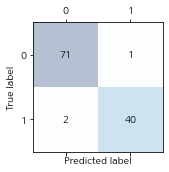

In [30]:
# 그림으로 나타내기

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

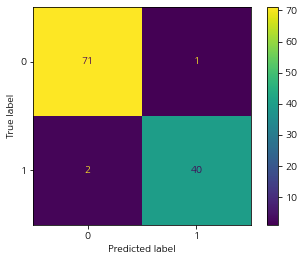

In [31]:
# another solution

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(pipe_svc, X_test, y_test)
plt.show()

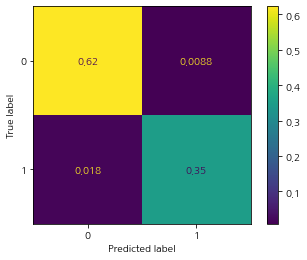

In [32]:
# another solution (2)

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(pipe_svc, X_test, y_test, normalize='all')
plt.show()

# 6.5.2 분류 모델의 정밀도와 재현율 최적화
예측오차(ERR)와 정확도(ACC)는 얼마나 많은 샘플을 잘못 분류했는지 일반적인 정보를 알려줌  
- 오차: 잘못된 예측의 합을 전체 예측 샘플 개수로 나눈 것
- 정확도: 옳은 예측의 합을 전체 예측 샘플 개수로 나눈 것
- 즉, ERR + ACC = 1  

TPR과 FPR은 클래스 비율이 다른 경우 유용한 성능 지표임

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1-score: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

정밀도: 0.976
재현율: 0.952
F1-score: 0.964


In [35]:
from sklearn.metrics import make_scorer,f1_score
scorer = make_scorer(f1_score, pos_label=0)
c_gamma_range = [0.01, 0.1, 1, 10.0]
param_grid = [{'svc__C': c_gamma_range, 'svc__kernel': ['linear']},
             {'svc__C': c_gamma_range, 'svc__gamma': c_gamma_range, 'svc__kernel':['rbf']}]
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring=scorer, cv=10)
gs = gs.fit(X_train,y_train)

print('Best Score: ', gs.best_score_) # 최상의 모델 점수
print('Best Parameters: ', gs.best_params_) # 이 모델의 매개변수 속성

Best Score:  0.9861994953378878
Best Parameters:  {'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


# 6.5.3 ROC 곡선 그리기

ROC 그래프는 분류기의 임계값을 바꾸어가며 계산된 FPR과 TPR 점수를 기반으로 분류 모델을 선택하는 유용한 도구  
ROC 그래프의 대각선은 랜덤 추측으로 해석할 수 있고, 대각선 아래에 위치한 분류 모델은 랜덤 추측보다 나쁨!  
-> 완벽한 분류기의 그래프는 TPR=1, FPR=0인 왼쪽 위 구석에 위치함!  
ROC 곡선의 아래 면적인 ROC AUC를 계산하여 모델의 성능을 종합할 수 있음

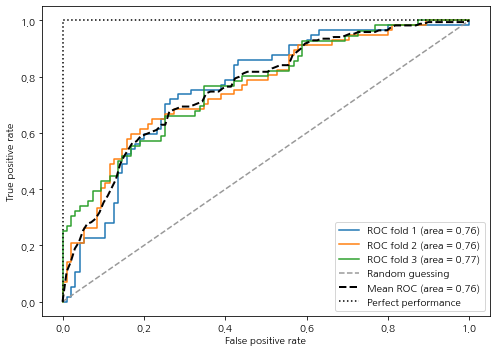

In [39]:
from sklearn.metrics import roc_curve, auc
from numpy import interp

pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(penalty='l2', random_state=1, C=100.0))

X_train2 = X_train[:,[4,14]]

cv = list(StratifiedKFold(n_splits=3, shuffle=True, random_state=1).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:,1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr, label='ROC fold %d (area = %0.2f)'%(i+1, roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

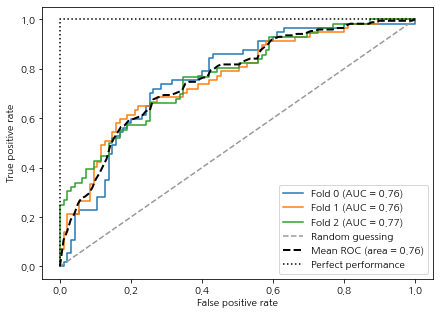

In [41]:
# another solution
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    pipe_lr.fit(X_train2[train], y_train[train])
    # roc_disp = plot_roc_curve(pipe_lr, X_train2[test], y_train[test], name=f'Fold {i}', ax=ax)
    roc_disp = RocCurveDisplay.from_estimator(pipe_lr, X_train2[test], y_train[test], name=f'Fold {i}', ax=ax)
    mean_tpr += interp(mean_fpr, roc_disp.fpr, roc_disp.tpr)
    mean_tpr[0] = 0.0

plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.show()

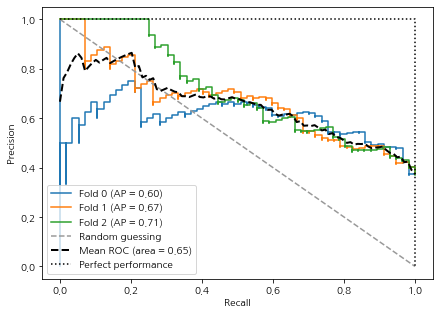

In [42]:
# 재현율-정밀도 곡선

from sklearn.metrics import PrecisionRecallDisplay

fig, ax = plt.subplots(figsize=(7, 5))

mean_precision = 0.0
mean_recall = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    pipe_lr.fit(X_train2[train], y_train[train])
    pr_disp = PrecisionRecallDisplay.from_estimator(pipe_lr, X_train2[test], y_train[test], name=f'Fold {i}', ax=ax)
    mean_precision += interp(mean_recall, pr_disp.recall[::-1], pr_disp.precision[::-1])

plt.plot([0, 1], [1, 0], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing')

mean_precision /= len(cv)
mean_auc = auc(mean_recall, mean_precision)
plt.plot(mean_recall, mean_precision, 'k--', label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 1, 1], [1, 1, 0], linestyle=':', color='black', label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.show()

# 6.5.4 다중 분류의 성능 지표
사이킷런은 평균 지표에 매크로와 마이크로 평균 방식을 구현하여 OvA 방식을 사용하는 다중분류로 확장  
- 매크로 평균: 단순하게 클래스별 정밀도의 평균 -> 모든 클래스에 동일한 가중치를 부여하여 전반적인 성능을 평가할 때 -> 빈도 높은 클래스 레이블의 성능이 중요!
- 마이크로 평균: TP, TN, FP, FN을 계산 -> 각 샘플이나 예측에 동일한 가중치를 부여하고자 할 때  

사이킷런에서는 기본적으로 마크로 평균이 적용됨. 이는 평균을 계산할 때 가중치를 주어 각 클래스 레이블의 샘플 개수를 가중하여 계산 -> 불균형한 클래스를 다룰 때 유용  
##### sklearn.metrics 모듈 아래에 있는 측정 함수들은 average 매개변수로 평균 계산 방식을 지정할 수 있음
###### pre_scorer = make_scorer(score_func = precision_score, pos_label=1, greater_is_better=True, avaerage='micro')